In [55]:
#import data
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [56]:
#read csv
df = pd.read_csv('creditcard_cc_fruad.csv')
df.head()   #seee first few column

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [57]:
#split feature and Class

x = df.drop('Class', axis=1)
y = df['Class']

shape = x.shape 
num_of_features = shape[1]
print(num_of_features) #see how many x feature in the dataset

30


In [58]:
# Split into training and testing datasets by train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, stratify=y)

In [59]:
#convert dataframe to tensor
x_train_tensor = torch.from_numpy(x_train.to_numpy()).float()
y_train_tensor = torch.from_numpy(y_train.to_numpy()).long() #to long as using CrossEntropyLoss, label need to be long
x_test_tensor = torch.from_numpy(x_test.to_numpy()).float()
y_test_tensor = torch.from_numpy(y_test.to_numpy()).long()

#tensor to tensor dataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

#tensor dataset to dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1024)  #large batch as interface
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024)

In [60]:
#decoder for classify two class from features output two logic
#30 features ->64 ->relu ->48 ->relu ->32 ->relu ->2 , in interface, argmax at last

class CcFruadClassifier(nn.Module):
    def __init__(self, num_of_features):
        super(CcFruadClassifier, self).__init__()
        self.fc1 = nn.Linear(num_of_features, 64)
        self.fc2 = nn.Linear(64, 48)
        self.fc3 = nn.Linear(48, 32)
        self.fc4 = nn.Linear(32, 2)  # Output layer for two-class classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


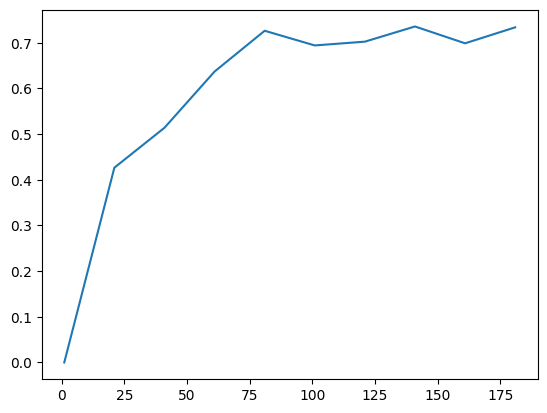

In [61]:
# check if can use cuda, no=cpu
device = "cuda" if torch.cuda.is_available() else "cpu"

#f1 and epoch list  for plot f1 epoch graph
f1_list=[]
epoch_list=[]

#evaluate each pt at different epoch generated at training
for epoch in (range(200)):
    if epoch %20 == 0:
        #load model
        model = CcFruadClassifier(num_of_features)
        model.load_state_dict(torch.load("checkpoint{}.pt".format(epoch+1), weights_only=True))
        model.eval().to(device)

        preds_list=[]
        labels_list=[]

        epoch_list.append(epoch+1)

        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            predicted_classes = torch.argmax(outputs, dim=1)    #final logic to argmax

            # Store predictions and labels
            preds_list.extend(predicted_classes.cpu().numpy().flatten())
            labels_list.extend(labels.cpu().numpy().flatten())

        f1_list.append(metrics.f1_score(labels_list, preds_list))

plt.plot(epoch_list, f1_list)
plt.show()

In [64]:
#f1 level off at around epoch 75, but around 125 adn 150 is higher, use 141

model.load_state_dict(torch.load("checkpoint141.pt".format(epoch+1), weights_only=True))
print('Confusion matrix: {}'. format(metrics.confusion_matrix(labels_list, preds_list)))
print('Accuracy score: {}'.format(metrics.accuracy_score(labels_list, preds_list)))
print(metrics.classification_report(labels_list, preds_list))

Confusion matrix: [[56855     9]
 [   36    62]]
Accuracy score: 0.9992099996488887
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.63      0.73        98

    accuracy                           1.00     56962
   macro avg       0.94      0.82      0.87     56962
weighted avg       1.00      1.00      1.00     56962



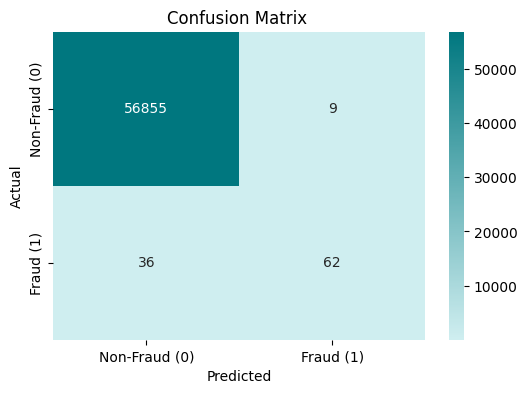

In [65]:
# Plot the confusion matrix
#this part code from https://www.kaggle.com/code/annastasy/anomaly-detection-credit-card-fraud
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

#Custom color palette
colors = ['#CFEEF0', '#00777F']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)


cm = confusion_matrix(labels_list, preds_list)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()